### Build env for this notebook (temp. fix):

Running this on CPU with different environment, as tensorflow does not support 5000-series Nvidia GPUs yet.

The SVM notebooks have to be executed first, as they create and export the feature data. Then this notebook is run in the dnn_cpu environment, see Readme.md


## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, balanced_accuracy_score

from subpred.evaluation import plot_results_long
from subpred.util import save_results, load_data

2025-06-10 16:55:44.290505: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 16:55:44.360959: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setting random seeds for all libraries. The seed for TF is a starting seed, and will get incremented with each call of Dropout(). Therefore, the notebook has to be restarted to get the same results again.

In [2]:
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)  

In [3]:
TEST_NAME = f"dnn_human_calciumpotassium"

Reading feature data from SVM notebook

In [4]:
# importing feature data from SVM notebooks (they have to be run first)
import pickle
with open("../data/tmp_data/svc_human_calciumpotassium_ml_data.pickle", "rb") as handle:
    ml_datasets = pickle.load(handle)

## Evaluation

In [5]:
for pos, ml_dataset in enumerate(ml_datasets):
    print(pos, ml_dataset.name, len(ml_dataset.feature_names))

0 DUMMY 1024
1 AAC 20
2 PAAC 400
3 AA_KMER3 8000
4 3Di_COMP 20
5 3Di_KMER2 400
6 3Di_KMER3 8000
7 COMB_KMER1 40
8 COMB_KMER2 800
9 COMB_KMER3 16000
10 PROTT5_AA 1024
11 PROSTT5_AA 1024
12 PROSTT5_3DI 1024
13 PSSM_50_1 400
14 PSSM_50_3 400
15 PSSM_90_1 400
16 PSSM_90_3 400
17 PSSM_META 1600
18 META 2020
19 META_STD 2020


Using the same metrics as with the SVM, to compare the results better

In [6]:
scoring_outer = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Macro": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, average="macro"
    ),
    "F1 Class 0": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=0
    ),
    "F1 Class 1": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=1
    ),
}


Caching of results. A new test always needs a new test_name, otherwise it reads the old results.

In [7]:
from subpred.dnn import crossval_dnn, create_model
from pathlib import Path
if Path(f"../data/results/{TEST_NAME}.pickle").exists():
    df_results_all = load_data(TEST_NAME, folder_path="../data/results")
else:
    results = [
        crossval_dnn(
            ml_dataset=ml_dataset,
            model_func=create_model,
            scores_dict=scoring_outer,
            splits=5,
            repeats=5,
            epochs=50,
            batch_size=8,
            calculate_class_weights=False,
            undersample=False,
            upsample=False
        )
        for ml_dataset in ml_datasets
    ]
    df_results_all = pd.concat(results)
    save_results(df_results_all,TEST_NAME, folder_path="../data/results")
        

=== DUMMY ===
=== AAC ===
=== PAAC ===
=== AA_KMER3 ===
=== 3Di_COMP ===
=== 3Di_KMER2 ===
=== 3Di_KMER3 ===
=== COMB_KMER1 ===
=== COMB_KMER2 ===
=== COMB_KMER3 ===
=== PROTT5_AA ===
=== PROSTT5_AA ===
=== PROSTT5_3DI ===
=== PSSM_50_1 ===
=== PSSM_50_3 ===
=== PSSM_90_1 ===
=== PSSM_90_3 ===
=== PSSM_META ===
=== META ===
=== META_STD ===


## Plots

In [8]:
# same plot as for svm, to compare
df_results_plot = df_results_all.copy()
df_results_plot.Feature = df_results_plot.Feature.str.replace("_", "-").replace("PSSM-META","MULTI-PSSM")
df_results_plot = df_results_plot[~df_results_plot.Feature.str.match(r'^PSSM-\d+')]
df_results_plot = df_results_plot[~df_results_plot.Feature.str.startswith("COMB")]
feature_order = [
    "DUMMY",
    "AAC",
    "PAAC",
    "AA-KMER3",
    # "PSSM-50-1",
    # "PSSM-50-3",
    # "PSSM-90-1",
    # "PSSM-90-3",
    # "PSSM-META",
    "MULTI-PSSM",
    "META",
    "META-STD",
    "PROTT5-AA",
    "PROSTT5-AA",
    "PROSTT5-3DI",
    "3Di-COMP",
    "3Di-KMER2",
    "3Di-KMER3",
    # "COMB-KMER1",
    # "COMB-KMER2",
    # "COMB-KMER3",
]

In [9]:
df_results_plot.Feature.unique()

array(['DUMMY', 'AAC', 'PAAC', 'AA-KMER3', '3Di-COMP', '3Di-KMER2',
       '3Di-KMER3', 'PROTT5-AA', 'PROSTT5-AA', 'PROSTT5-3DI',
       'MULTI-PSSM', 'META', 'META-STD'], dtype=object)

saves plot with test name and metrics in name

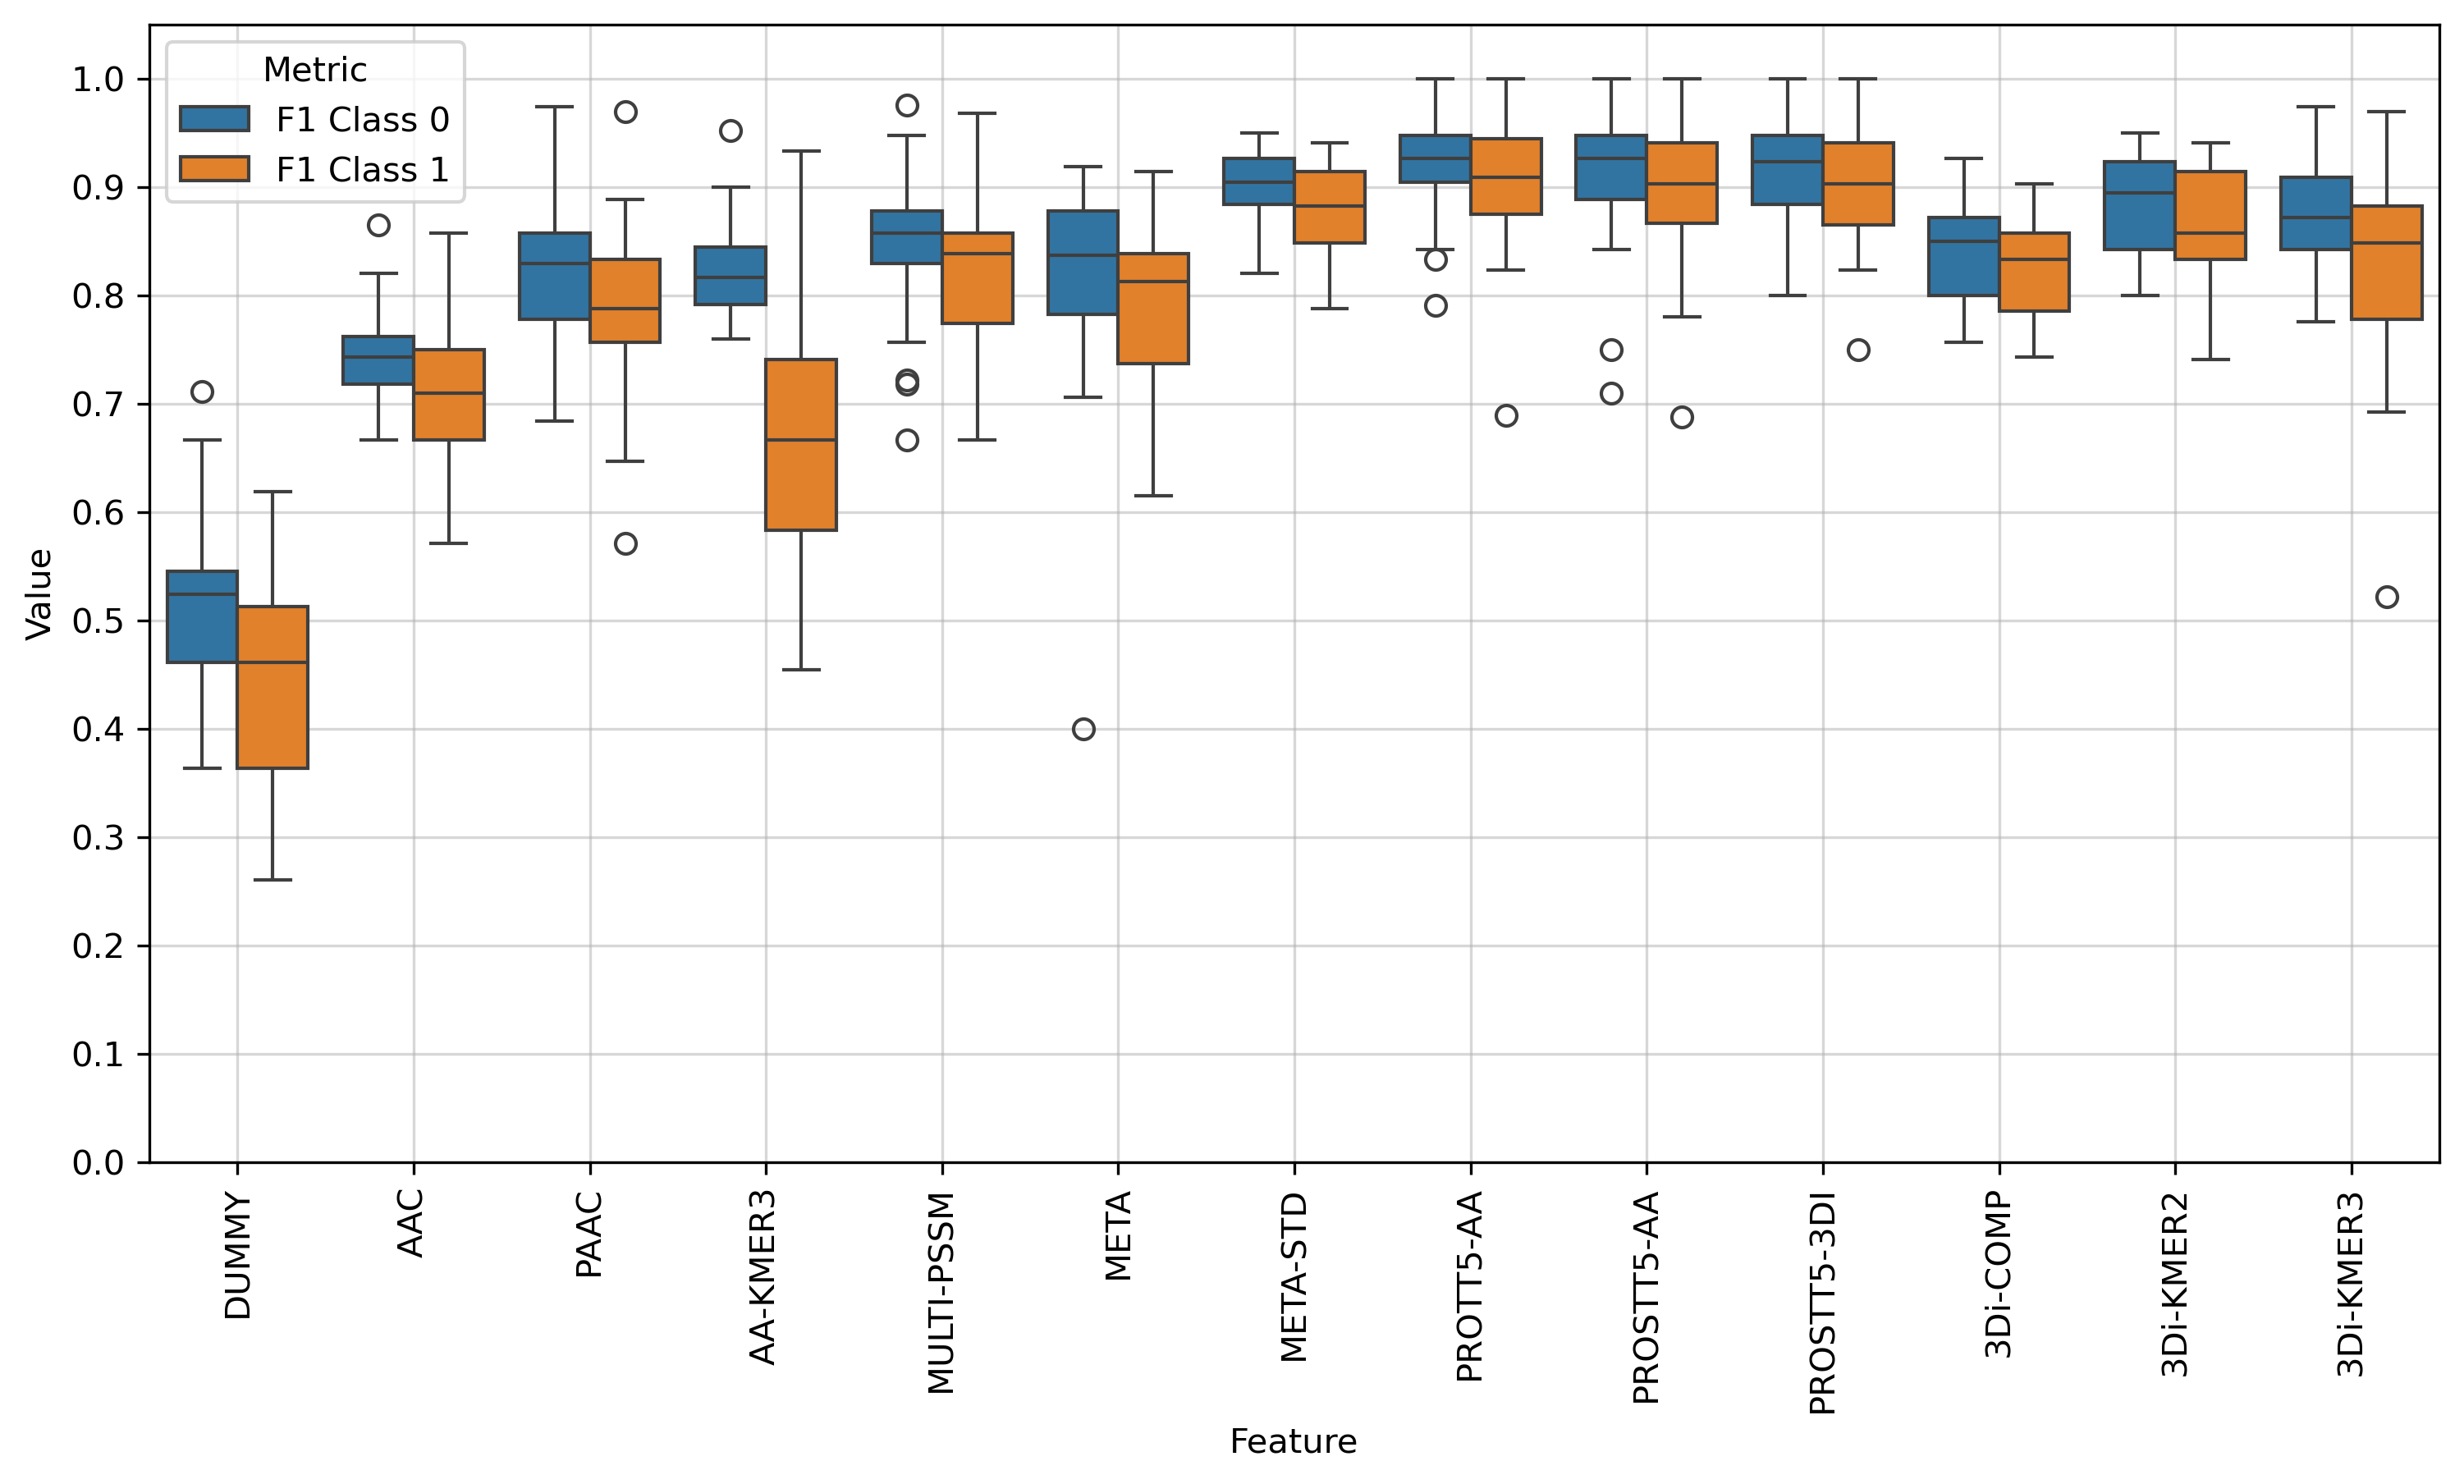

In [10]:
plot_results_long(
    df_results_long=df_results_plot,
    output_folder_path="../data/results/",
    test_name=TEST_NAME,
    plot_order=feature_order,
    metrics_include=["F1 Class 0", "F1 Class 1"],
)

## Tables

In [11]:
df_table = df_results_all.copy()
df_table.Feature = df_table.Feature.str.replace("_", "-").replace("PSSM-META","MULTI-PSSM")
df_table = df_table[~df_table.Feature.str.match(r'^PSSM-\d+')]
feature_order = [
    "DUMMY",
    "AAC",
    "PAAC",
    "AA-KMER3",
    # "PSSM-META",
    "MULTI-PSSM",
    "META",
    "META-STD",
    "COMB-KMER1",
    "COMB-KMER2",
    "COMB-KMER3",
    "PROTT5-AA",
    "PROSTT5-AA",
    "PROSTT5-3DI",
    # "PSSM-50-1",
    # "PSSM-50-3",
    # "PSSM-90-1",
    # "PSSM-90-3",
    "3Di-COMP",
    "3Di-KMER2",
    "3Di-KMER3",
]

df_table_mean = df_table.groupby(["Feature", "Metric"]).mean().reset_index().pivot(
    index="Feature", columns="Metric", values="Value"
)
df_table_std = df_table.groupby(["Feature", "Metric"]).std().reset_index().pivot(
    index="Feature", columns="Metric", values="Value"
)

df_table_paper = df_table_mean.map(lambda x: f"{x:.3f}").astype(str) + "±" + df_table_std.map(lambda x: f"{x:.3f}").astype(str)
df_table_paper = df_table_paper.loc[feature_order]
df_table_paper

Metric,Balanced Accuracy,F1 Class 0,F1 Class 1,F1 Macro
Feature,,,,
DUMMY,0.485±0.065,0.512±0.085,0.443±0.096,0.477±0.062
AAC,0.728±0.055,0.744±0.044,0.706±0.075,0.725±0.053
PAAC,0.805±0.074,0.824±0.067,0.786±0.085,0.805±0.075
AA-KMER3,0.760±0.070,0.827±0.042,0.677±0.118,0.752±0.080
MULTI-PSSM,0.834±0.071,0.844±0.070,0.823±0.076,0.833±0.072
META,0.807±0.076,0.813±0.105,0.794±0.078,0.803±0.084
META-STD,0.889±0.038,0.901±0.037,0.880±0.042,0.891±0.038
COMB-KMER1,0.849±0.049,0.860±0.047,0.837±0.054,0.848±0.049
COMB-KMER2,0.860±0.053,0.876±0.048,0.845±0.064,0.861±0.054


In [12]:
df_table_paper.columns.name = None
print(
    df_table_paper.reset_index(drop=False)
    .drop("F1 Macro", axis=1)
    .to_latex(index=False)
    .replace("tabular", "tabular*")
    .replace("{llll}", "{\\textwidth}{@{\\extracolsep{\\fill}} lrrr}")
)

\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}} lrrr}
\toprule
Feature & Balanced Accuracy & F1 Class 0 & F1 Class 1 \\
\midrule
DUMMY & 0.485±0.065 & 0.512±0.085 & 0.443±0.096 \\
AAC & 0.728±0.055 & 0.744±0.044 & 0.706±0.075 \\
PAAC & 0.805±0.074 & 0.824±0.067 & 0.786±0.085 \\
AA-KMER3 & 0.760±0.070 & 0.827±0.042 & 0.677±0.118 \\
MULTI-PSSM & 0.834±0.071 & 0.844±0.070 & 0.823±0.076 \\
META & 0.807±0.076 & 0.813±0.105 & 0.794±0.078 \\
META-STD & 0.889±0.038 & 0.901±0.037 & 0.880±0.042 \\
COMB-KMER1 & 0.849±0.049 & 0.860±0.047 & 0.837±0.054 \\
COMB-KMER2 & 0.860±0.053 & 0.876±0.048 & 0.845±0.064 \\
COMB-KMER3 & 0.804±0.071 & 0.853±0.047 & 0.748±0.114 \\
PROTT5-AA & 0.915±0.056 & 0.924±0.048 & 0.907±0.064 \\
PROSTT5-AA & 0.904±0.064 & 0.910±0.066 & 0.897±0.067 \\
PROSTT5-3DI & 0.908±0.053 & 0.915±0.049 & 0.901±0.058 \\
3Di-COMP & 0.832±0.042 & 0.841±0.045 & 0.821±0.046 \\
3Di-KMER2 & 0.877±0.048 & 0.888±0.046 & 0.866±0.056 \\
3Di-KMER3 & 0.855±0.072 & 0.878±0.057 & 0.833±0.099 \\
\bo